### reinforcement-learning simple gridworld
this object-oriented script requires two object classes: `world` and `agent`
1. class `world` implements game mechanics (as deterministic MDP) and enables agent to interact with the environment
    - constructor requires 2D numpy array of arbitrary size which is used to construct gridworld; different entries of this array denote objects like: 
        - mandatory fields:
            - <span style="color:black">regular field <b>(code 0)</b></span> agent can move freely on these fields
            - <span style="color:black">respawn field <b>(code 1)</b></span> agent appears on this field after death or after finding the reward
            - <span style="color:#DAA520">reward field <b>(code 2)</b></span> contains terminal rewarding state
        - barriers:
            - <span style="color:#CCCCCC">wall field <b>(code -1)</b></span> these fields cannot be achieved
            - <span style="color:#333333">hole field <b>(code -2)</b></span> after moving to hole field agent dies and moves to the respawn field
        - stochastic obstacles:
            - <span style="color:black">isotropic wind <b>(code -3)</b></span> after leaving this field agent sometimes makes random move  
            - <span style="color:#663300">mud field <b>(code -4)</b></span> after choosing an action sometimes nothing happens
        - teleports:
            - <span style="color:#0000FF">teleport field <b>(code 10)</b></span> after moving to teleport field agent appears in entangled teleport
    - `move` method executes selected action and returns associated reward; actions are coded: left (0), right (1), up (2), down (3)
    - `draw` method draws actual state of the world 
    
    
2. class `agent` implements SARSA($\lambda$) algorithm to solve gridworld problem
    - constructor requires gridsize – 2-element list of gridworld width and length, loc_start – initial state, and four algorithm parameters (alpha, gamma, epsilon and lambda)
    - `reset_et` method resets eligibility traces 
    - `update_position` method takes world instance as an argument and updates agent's current state
    - `eps_greedy` method implements $\epsilon$-greedy policy improvement part
    - `update` method implements SARSA($\lambda$) policy evaluation step comprised of TD-error calculation, eligibility increment for recently visited state, global update of state-action values, global decay of eligibility traces 
    - `cool` method made for visualisation is plotting two figures representing:
        - policy representation and gridworld state representation (left panel)
        - value function (right panel)

In [209]:
class world:
    
    import numpy as np
    import random
        
    def __init__(self, grid, settings):
        #--- this will change
        self.player = np.asarray(np.nonzero(grid == 1)).T[0] # player actual position
        #--- those are fixed
        self.grid = np.copy(grid) 
        self.gridsize = grid.shape
        self.startpos = np.asarray(np.nonzero(grid == 1)).T[0]
        if 10 in grid:
            self.teleport = np.transpose(np.nonzero(grid == 10))
        self.settings = settings.copy()
        
    def move(self, a):
        r = self.settings['reward_move']
        if self.isField(self.player, -4): # test mud
            if random.random() < self.settings['mud_slow_rate']: 
                return r
        if self.isField(self.player, -3): # test wind
            if random.random() < self.settings['wind_rand_rate']:
                #--- choose random action
                a = random.randint(0,3) 
        #--- calculate new position on the grid
        newpos = self.player + np.array([int(np.floor(a/2)) * ((a - 2) * 2 - 1), 
                                         int(not bool(np.floor(a / 2))) * (a * 2 - 1)])
        if not self.isInBounds(newpos):   # test boundaries
            return r
        if self.isField(newpos, -2):      # test hole
            self.player = self.startpos
            return self.settings['reward_death']
        if self.isField(newpos, 2):       # test goal
            self.player = self.startpos
            return self.settings['reward_goal']
        if self.isField(newpos, 10):      # test teleport
            self.player = self.teleport[np.nonzero(np.sum(~(newpos == self.teleport), axis=1))[0][0]]
            return r
        self.player = newpos
        return r
            
    def isInBounds(self, pos):
        return not ((pos < 0).any() or 
                    (pos[0] > self.gridsize[0] - 1) or 
                    (pos[1] > self.gridsize[1] - 1) or
                    (self.grid[pos[0], pos[1]] == -1)) 

    def isField(self, pos, code):
        return self.grid[pos[0],pos[1]] == code
        
    def draw(self):
        
        import matplotlib.pyplot as plt
        
        fig = plt.matshow(self.grid);
        ax = plt.gca()

        #--- shift & disable ticks
        ax.set_xticks(np.arange(-.5, self.grid.shape[0], 1))
        ax.set_yticks(np.arange(-.5, self.grid.shape[1], 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        plt.tick_params(
            axis='both',       
            bottom=False,      
            top=False,         
            left=False,
            right=False,
            labelbottom=False)
        #--- draw additional lines
        ax.grid(color='w', linestyle='-', linewidth=1)
        #--- colors
        plt.set_cmap('RdYlBu')

class agent:
    
    import numpy as np
    import random
        
    def __init__(self, gridsize, loc_start, alpha, gamma, epsilon, lambd, v0):
        #--- algorithm parameters
        self.alpha = alpha  
        self.gamma = gamma 
        self.epsilon = epsilon
        self.lambd = lambd
        #--- policy representation
        self.q = v0 * np.ones((gridsize[0], gridsize[1], 4)) # initial state-action values
        self.et = np.zeros((gridsize[0], gridsize[1], 4))    # eligibility trace matrix
        self.player = np.array([loc_start[0], loc_start[1]]) # current position
        #--- for visuals
        self.gridsize = gridsize
        
    def reset_et(self):
        self.et = np.zeros((gridsize[0], gridsize[1], 4))
        
    def update_position(self, world):
        self.player = world.player
            
    def eps_greedy(self):
        if random.random() < self.epsilon:
            #--- random action
            return random.randint(0,3)
        else:
            #--- greedy action
            weights = self.q[self.player[0]][self.player[1]]
            return random.choice(np.nonzero(weights == max(weights))[0])
                    
    def update(self, s, a, r, s_, a_):
        #--- calculate td error
        if r != 1:
            td_error = r + self.gamma * self.q[s_[0], s_[1], a_] - self.q[s[0], s[1], a]
        else:
            #==!== caveat
            td_error = r - self.q[s[0], s[1], a]
        #--- add trace
        self.et[s[0], s[1], a] += 1
        #--- update q-values
        self.q = self.q + self.alpha * td_error * self.et
        #--- decay trace
        self.et = self.gamma * self.lambd * self.et
        return td_error
        
    def cool(self, grid):
    
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches
    
        X, Y = np.meshgrid(np.arange(0.5, self.gridsize[1] + .5, 1), 
                           np.arange(self.gridsize[0] - 0.5, -0.5, -1))
        U = self.q[:,:,1] - self.q[:,:,0] # x-component of arrow
        if np.max(abs(U)) != 0:
            U = (1/2) * U / np.max(abs(U))
        V = self.q[:,:,2] - self.q[:,:,3] # y-component of arrow 
        if np.max(abs(V)) != 0:
            V = (1/2) * V / np.max(abs(V))
        C = np.amax(self.q, axis=2)  # color

        fig = plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k');
        
        #=== policy representation
        plt.set_cmap('RdYlGn')    # arrow cmap
        
        ax1 = fig.add_subplot(131, aspect='equal')
        ax1.set_xticks(np.arange(0, self.gridsize[1], 1))
        ax1.set_yticks(np.arange(0, self.gridsize[0], 1))
        ax1.set_xlim([0, self.gridsize[1]])
        ax1.set_ylim([0, self.gridsize[0]])
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        ax1.grid(color='k', linestyle='-', linewidth=1, alpha=0.1)
        
        ax1.quiver(X, Y, U, V, C,
                  angles='xy', scale_units='xy', scale=1) # draw arrows
        
        ax1.tick_params(          # disable ticks
            axis='both',       
            bottom=False,      
            top=False,         
            left=False,
            right=False,
            labelbottom=False)

        #--- draw holes and goal
        for ix,iy in np.ndindex(w.grid.shape):
            if grid[ix,iy] == 2:  # reward
                ax1.add_patch(
                    patches.Rectangle((iy, self.gridsize[0] - ix - 1), 1, 1, color='#DAA520', alpha=0.5))
            if grid[ix,iy] == -1: # wall
                ax1.add_patch(
                    patches.Rectangle((iy, self.gridsize[0] - ix - 1), 1, 1, color='#CCCCCC', alpha=1))
            if grid[ix,iy] == -2: # hole
                ax1.add_patch(
                    patches.Rectangle((iy, self.gridsize[0] - ix - 1), 1, 1, color='#333333', alpha=1))        
            if grid[ix,iy] == -3: # wind
                ax1.add_patch(
                    patches.FancyBboxPatch((iy + 0.4, self.gridsize[0] - ix - 0.6), 0.2, 0.2, color='#000000', 
                                           alpha = 0.1, 
                                           boxstyle='sawtooth'))
            if grid[ix,iy] == -4: # mud
                ax1.add_patch(
                    patches.Rectangle((iy, self.gridsize[0] - ix -1), 1, 1, color='#663300', 
                                      alpha=0.3,
                                      linewidth=0))
            if grid[ix,iy] == 10: # teleport
                ax1.add_patch(
                    patches.Rectangle((iy, self.gridsize[0] - ix -1), 1, 1, color='#0000FF', alpha=0.5))

        #--- draw agent position
        ax1.add_patch(
            patches.Circle((self.player[1] + 0.5, self.gridsize[0] - self.player[0] - 0.5), 0.3,
                           color='black', alpha = 0.5))
        
        #=== state-value function
        ax2 = fig.add_subplot(132, aspect='equal')
        ax2.matshow(np.amax(self.q, axis=2))
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])
        ax2.tick_params(          
            axis='both',       
            bottom=False,      
            top=False,         
            left=False,
            right=False,
            labelbottom=False)
        ax2.set_title('State value function $v(s)$')
        
        #=== eligibility trace
        plt.set_cmap('binary')
        
        ax3 = fig.add_subplot(133, aspect='equal')
        ax3.matshow(np.sum(self.et, axis=2))
        ax3.set_xticklabels([])
        ax3.set_yticklabels([])
        ax3.tick_params(          
            axis='both',       
            bottom=False,      
            top=False,         
            left=False,
            right=False,
            labelbottom=False)
        ax3.set_title('Eligibility trace')
        
        #--- add grid numeric values
        for (i, j), z in np.ndenumerate(np.amax(self.q, axis=2)):
            ax2.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='white')

def draw_learning_curve(timestep, timeepsilon, lylabel, rylabel, title, palette):

    fig = plt.figure(num=None, figsize=(15, 3), dpi=80, facecolor='w', edgecolor='k')

    if palette == 1:
        col1 = '#B10029'
        col2 = '#006939'
    else: 
        col1 = '#0000FF'
        col2 = '#DAA520'
        
    ax1 = fig.add_subplot(111)
    ax1.plot(timestep, color=col1)
    ax1.tick_params(axis='y', labelcolor=col1)
    ax1.set_title(title)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel(lylabel)

    ax2 = ax1.twinx()
    ax2.plot(timeepsilon, color=col2)
    ax2.tick_params(axis='y', labelcolor=col2)
    ax2.set_ylabel(rylabel)
    
    plt.show()

def read_map(path):
    import pandas as pd
    g = pd.read_csv(path)
    grid = g.values[:,1:]
    return grid

### map creator
here user can create his own gridworlds using parameters and save map to csv file

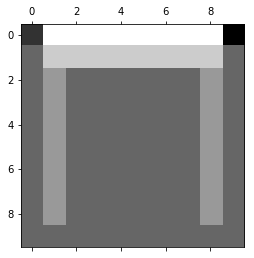

In [228]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

#======= change this ===========================
ifSave = False
folder = 'maps/'
map_name = 'test2'
#--- map object positions
gridsize = [10,10]
pos_start = [0,0]
pos_reward = [0,9]
pos_wall = [[2,1],[3,1],[4,1],[5,1],[6,1],[7,1],[8,1],
            [2,8],[3,8],[4,8],[5,8],[6,8],[7,8],[8,8]]
pos_holes = [[1,1],[1,2],[1,3],[1,4],[1,5],[1,6],[1,7],[1,8]]
pos_mud = []
pos_wind = [[0,1],[0,2],[0,3],[0,4],[0,5],[0,6],[0,7],[0,8]]
pos_tp = []
#===============================================

#--- create map 
grid = np.zeros((gridsize[0], gridsize[1]))
grid[pos_start[0]][pos_start[1]] = 1
grid[pos_reward[0]][pos_reward[1]] = 2
for wall in pos_wall:
    grid[wall[0],wall[1]] = -1
for hole in pos_holes:
    grid[hole[0],hole[1]] = -2
for wind in pos_wind:
    grid[wind[0],wind[1]] = -3
for mud in pos_mud:
    grid[mud[0],mud[1]] = -4
for tp in pos_tp:
    grid[tp[0],tp[1]] = 10
    
#--- show simple representation
plt.matshow(grid)

#--- save maze map to file
df = pd.DataFrame(grid)
df.to_csv(folder + map_name + '.csv')

### user settings 
here user can change maps / gridworlds and test different algorithm parameters

In [237]:
#--- simulation options
N_episodes = 1000  # number of episodes
settings = {
    "reward_move": -1, 
    "reward_death": -1,
    "reward_goal": 1,
    "mud_slow_rate": 0.1,
    "wind_rand_rate": 0.1
}
#map_path = 'maps/test.csv'

#--- SARSA parameters
alpha = 0.7        # learning rate
gamma = 1          # discount factor 
epsilon = 0.1      # controls amount of exploration
lambd = 0.7        # controls bias/variance tradeoff
v0 = 0             # initial state action values

#--- display options
iter_to_show = [1000] # on which iterations to show behavior

### run algorithm
main part of the script, algorithm will learn how to solve the maze

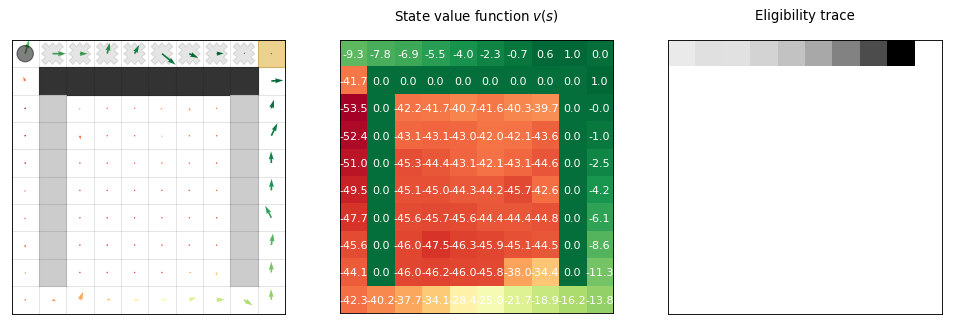

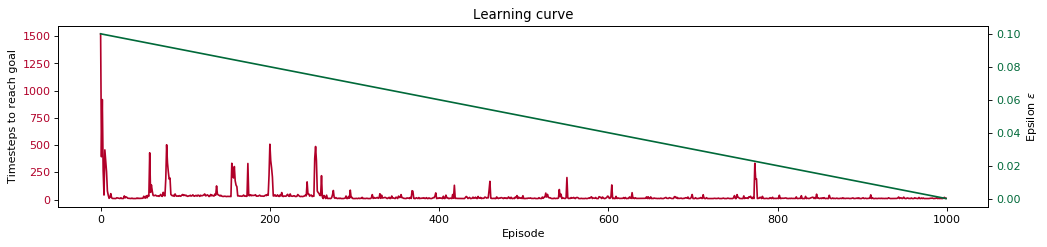

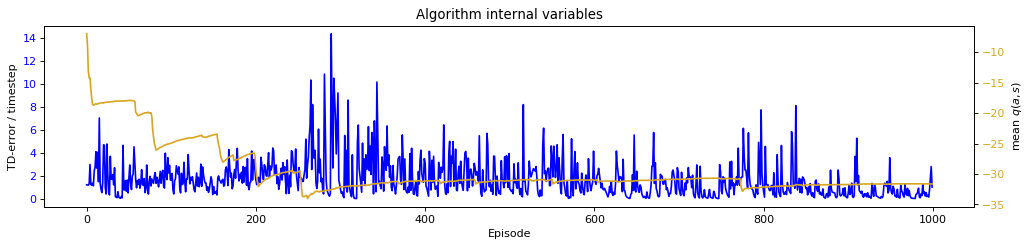

=== Info ==============================================
Learning complete!
SARSA time elapsed 0.45852065086364746 seconds
Mean number of steps to reach goal was 30.52
Best result (shortest path) was 9.0


In [238]:
from IPython import display
import matplotlib.pyplot as plt
import time
import random
%matplotlib inline

#--- initialize environment and agent
#grid = read_map(map_path)
w = world(grid, settings)
p = agent(gridsize, pos_start, alpha, gamma, epsilon, lambd, v0)
#--- grab additional statistics
timestep = np.zeros(N_episodes)
timeepsilon = np.linspace(epsilon, 0, N_episodes)
timetime = np.zeros(N_episodes)
timevalue = np.zeros(N_episodes)
timerror = np.zeros(N_episodes)

#--- run algorithm
for episode in range(N_episodes):
        
    p.reset_et()                     # reset eligibility
    p.epsilon = timeepsilon[episode] # decay exploration
    s = w.player                     # initial position
    a = p.eps_greedy()               # initial action
    r = 0
    
    while r != 1:    
        
        r = w.move(a)             # do action & get reward
        p.update_position(w)      # update agent position
        s_ = w.player             # get next state
        t_start = time.time()
        a_ = p.eps_greedy()       # get next action
        error = p.update(s, a, r, s_, a_) # here magic happens
        t_end = time.time()
        s = s_
        a = a_
        
        timetime[episode] += t_end - t_start
        timestep[episode] += 1    # increment counter
        timerror[episode] += abs(error)
        
        #--- see algorithm in action
        if episode + 1 in iter_to_show:
            p.cool(w.grid)
            display.clear_output(wait=True)
            display.display(plt.gcf())
            time.sleep(.05)
            plt.close()
            
    timevalue[episode] = np.mean(p.q)

#--- visuals & additional informations
draw_learning_curve(timestep, timeepsilon, 'Timesteps to reach goal','Epsilon $\epsilon$', 'Learning curve', 1)
draw_learning_curve(timerror/timestep, timevalue, 'TD-error / timestep', 'mean $q(a,s)$', 'Algorithm internal variables', 2)
print('=== Info ==============================================')
print('Learning complete!')
print(f'SARSA time elapsed {np.sum(timetime)} seconds')
print(f'Mean number of steps to reach goal was {np.mean(timestep)}')
print(f'Best result (shortest path) was {np.min(timestep)}')
print('=======================================================')